<a href="https://colab.research.google.com/github/AritraStark/E2E_GSOC_2022/blob/main/E2E_eval_task_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Common Task 1. Electron/photon classification**

Datasets:

https://cernbox.cern.ch/index.php/s/AtBT8y4MiQYFcgc (photons)

https://cernbox.cern.ch/index.php/s/FbXw3V4XNyYB3oA (electrons)

Description: 32x32 matrices (two channels - hit energy and time) for two classes of particles electrons and photons impinging on a calorimeter
Please use a deep learning method of your choice to achieve the highest possible
classification on this dataset (we ask that you do it both in Keras/Tensorflow and in PyTorch). Please provide a Jupyter notebook that shows your solution. The model yousubmit should have a ROC AUC score of at least 0.80.

Downloading the datasets from the links provided: 

In [1]:
!wget https://cernbox.cern.ch/index.php/s/AtBT8y4MiQYFcgc/download -O photons.hdf5
!wget https://cernbox.cern.ch/index.php/s/FbXw3V4XNyYB3oA/download -O electrons.hdf5

--2022-03-21 17:22:32--  https://cernbox.cern.ch/index.php/s/AtBT8y4MiQYFcgc/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.28, 128.142.53.35, 137.138.120.151, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119703858 (114M) [application/octet-stream]
Saving to: ‘photons.hdf5’

photons.hdf5        100%[===================>] 114.16M   127MB/s    in 0.9s    

Last-modified header invalid -- time-stamp ignored.
2022-03-21 17:22:34 (127 MB/s) - ‘photons.hdf5’ saved [119703858/119703858]

--2022-03-21 17:22:35--  https://cernbox.cern.ch/index.php/s/FbXw3V4XNyYB3oA/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.28, 128.142.53.35, 137.138.120.151, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128927319 (123M) [application/octet-stream]
Saving to: ‘electrons.hdf5’

electr

Setting up the imports:

In [2]:
import numpy as np
import tensorflow as tf
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

print(tf.__version__)

2.8.0


Get the data from the downloaded HDF5 files and combine the loaded datasets:

In [3]:
X_electron = np.array(h5py.File("electrons.hdf5",'r').get(name="X")[()])
y_electron = np.array(h5py.File("electrons.hdf5",'r').get(name="y")[()])
X_photon = np.array(h5py.File("photons.hdf5",'r').get(name="X")[()])
y_photon = np.array(h5py.File("photons.hdf5",'r').get(name="y")[()])

X_particles = np.concatenate((X_electron,X_photon),axis=0)
y_particles = np.concatenate((y_electron,y_photon),axis=0)
print(X_particles.shape,y_particles.shape)

del X_electron
del X_photon
del y_electron
del y_photon

(498000, 32, 32, 2) (498000,)


Flattening the data: 

In [4]:
stream_data = X_particles[:,:,:,0].reshape(-1,32*32)
stream_data.shape

(498000, 1024)

Randomizing data:

In [5]:
np.random.seed(48)
rng_state = np.random.get_state()
np.random.shuffle(stream_data)
np.random.set_state(rng_state)
np.random.shuffle(y_particles)

Splitting the data into training and testing sets ( I have split it in 80-20 as per instructions): 

In [6]:
X_train, X_test, y_train, y_test = train_test_split( stream_data, y_particles, random_state=48, test_size=0.2 )


Defining the model:

In [13]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(512, activation = 'relu', input_shape =X_train.shape[1:]),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(256, activation = 'relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128, activation = 'relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(64, activation = 'relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1, activation = 'sigmoid')
])

Defining callbacks:

In [14]:
filepath="classifier_weights2-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint1 = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]

Compiling the model and fitting it with testing data:

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(X_train,  y_train, 
                    validation_split=0.2, 
                    epochs=200, 
                    batch_size=2000,
                    callbacks=callbacks_list)

Epoch 1/200
157/160 [============================>.] - ETA: 0s - loss: 0.6487 - accuracy: 0.6227
Epoch 1: val_accuracy improved from -inf to 0.69004, saving model to classifier_weights2-improvement-01-0.69.hdf5
160/160 [==============================] - 4s 19ms/step - loss: 0.6481 - accuracy: 0.6235 - val_loss: 0.5976 - val_accuracy: 0.6900
Epoch 2/200
160/160 [==============================] - ETA: 0s - loss: 0.5983 - accuracy: 0.6909
Epoch 2: val_accuracy improved from 0.69004 to 0.70747, saving model to classifier_weights2-improvement-02-0.71.hdf5
160/160 [==============================] - 3s 17ms/step - loss: 0.5983 - accuracy: 0.6909 - val_loss: 0.5777 - val_accuracy: 0.7075
Epoch 3/200
160/160 [==============================] - ETA: 0s - loss: 0.5833 - accuracy: 0.7051
Epoch 3: val_accuracy did not improve from 0.70747
160/160 [==============================] - 3s 16ms/step - loss: 0.5833 - accuracy: 0.7051 - val_loss: 0.5775 - val_accuracy: 0.7074
Epoch 4/200
160/160 [==========

Plotting the results:

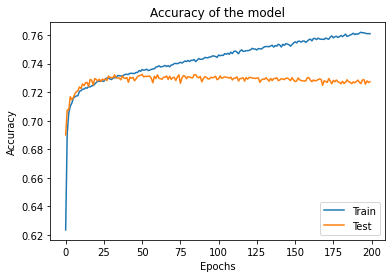

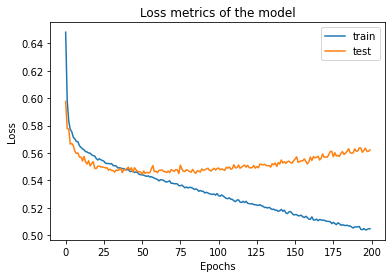

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy of the model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss metrics of the model')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Check the performance of the model on predictions:

In [ ]:
best_epoch=np.argmax(history.history['val_accuracy'])
best_acc=np.max(history.history['val_accuracy'])
model.load_weights(f"classifier_weights2-improvement-{best_epoch+1}-{best_acc:.2f}.hdf5")
predictions = model.predict(X_train)
bin =[0 if p<0.5 else 1 for p in predictions]

In [12]:
print(classification_report(y_train,bin))
roc_auc_score(y_train, bin)

              precision    recall  f1-score   support

         0.0       0.75      0.72      0.74    199124
         1.0       0.73      0.76      0.75    199276

    accuracy                           0.74    398400
   macro avg       0.74      0.74      0.74    398400
weighted avg       0.74      0.74      0.74    398400



0.741123700089779

**References :**


1.   [Examining Electron and Photon Classification Using Convolutional Neural Networks
Jonah Warner, Research Assistant
Department of Physics, Carnegie Mellon University, Pittsburgh 15213](https://www.cmu.edu/ai-physics-institute/outreach/surp/images/2021/jonah-warner-poster.pdf)
2.   [End-to-End Event Classification of High-Energy
Physics Data
M Andrews
, M Paulini
, S Gleyzer
, B Poczos](https://indico.cern.ch/event/567550/papers/2629451/files/7515-end-end-event_v4.pdf)
3.   [Calorimetry with Deep Learning: Particle
Classification, Energy Regression, and Simulation for
High-Energy Physics
Federico Carminati, Gulrukh Khattak, Maurizio Pierini
CERN](https://dl4physicalsciences.github.io/files/nips_dlps_2017_15.pdf)
4.  [Electron/Photon Ambiguity Resolution Using Neural
networks For ATLAS Experiment
Nutthawara Buatthaisong, Khon Kaen University, Thailand
](https://www.desy.de/f/students/2019/reports/nutthawara.buatthaisong.pdf)
